# Exploration of original cases

In this notebook we explore the characteristics of the original artificial cases datasets. We aim to answer the following questions:
- How many cases are there?
- How long are they?
- How many unique tokens are there?
- Are all of they structured in the same way?

We also have some metadata about the cases containing the MeSH terms in it. We will explore the distribution of these terms in the cases.

In [1]:
import pandas as pd
import os

import matplotlib.pyplot as plt

main_path = "data/1_original/txt"

In [2]:
filename = os.path.join(main_path, "25350173.txt")
content = open(filename, "r").read()

content

'A 64-year-old female lifelong smoker with no previous cardiac history presented with a 4-day history of dyspnoea on minimal exertion (New York Heart Association class III). Electrocardiography showed broad complex monophasic ventricular tachycardia (VT) and troponin T was elevated. She was treated initially with intravenous amiodarone and adenosine with no sustained effect.\n\nTransthoracic echocardiography showed a severely dilated left ventricle (LV) with a large aneurysm and severely impaired ventricular function. The ejection fraction was less than 10%. Coronary angiography showed a long segment of moderate to severe disease in the left coronary system and a small right coronary artery with no flow limiting disease. Recurrent intermittent episodes of VT became persistent and intractable. Direct current cardioversion was attempted on at least 20 separate occasions, resulting in only transient amelioration of arrhythmia. Percutaneous coronary intervention was undertaken successfully

# Data Exploration

## Amount of data

In [3]:
n_cc = len(os.listdir(main_path))
print("There are {} clinical cases".format(n_cc))

There are 1000 clinical cases


In [4]:
def extract_txt(path, filename):
    total_path = os.path.join(path, filename)
    return filename, open(total_path, "r").read()

filename = "25350173.txt"

def files_to_df(path, extensions=["txt"]):
    files = [x for x in os.listdir(path) if x.split(".")[-1] in extensions]
    data = [extract_txt(path, f) for f in files]
    return pd.DataFrame(data, columns=["filename", "text"])

df = files_to_df(main_path)

In [5]:
df.head()

,filename,text
0,33175723_1.txt,"Patient: Male, 63-year-old\n\n\nFinal Diagnosi..."
1,36305455.txt,"In November 1990, a 25‐year‐old male patient w..."
2,31668014.txt,A 67‐year‐old man treated with hemodialysis wa...
3,32153696.txt,An 80-year-old man who worked as a constructio...
4,32470561.txt,A 46-years-old female was admitted to our depa...


In [10]:
# Include the number of RoBERTa tokens
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [11]:
df["n_char"] = df["text"].str.len()
df["n_words"] = df["text"].str.split("\n|\s").str.len()
df["n_tokens"] = df["text"].apply(lambda x: len(tokenizer(x)["input_ids"]))
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors


,filename,text,n_char,n_words,n_tokens
0,33175723_1.txt,"Patient: Male, 63-year-old\n\n\nFinal Diagnosi...",1509,212,376
1,36305455.txt,"In November 1990, a 25‐year‐old male patient w...",4010,580,876
2,31668014.txt,A 67‐year‐old man treated with hemodialysis wa...,4757,733,1107
3,32153696.txt,An 80-year-old man who worked as a constructio...,1680,246,355
4,32470561.txt,A 46-years-old female was admitted to our depa...,1997,295,432


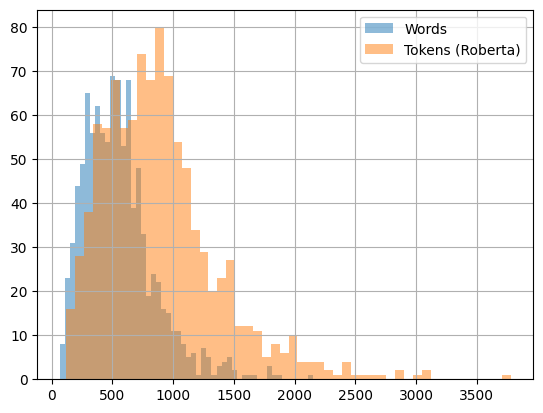

In [16]:
df["n_words"].hist(bins=50, alpha=0.5, label="Words");
df["n_tokens"].hist(bins=50, alpha=0.5, label="Tokens (Roberta)");
plt.legend();

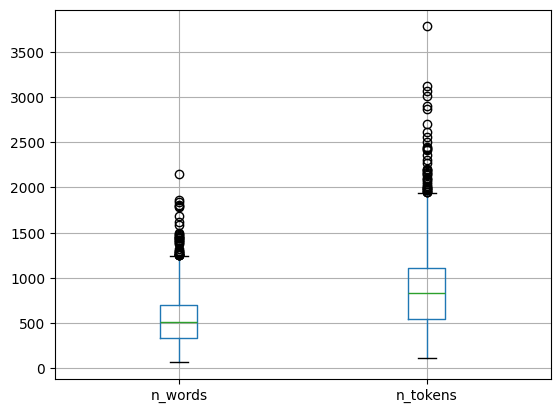

In [19]:
df.boxplot(column=["n_words", "n_tokens"]);

In [17]:
df.describe()

,n_char,n_words,n_tokens
count,1000.000000,1000.000000,1000.000000
mean,3731.179000,552.612000,890.068000
std,1991.746719,294.424107,482.138234
min,445.000000,67.000000,119.000000
25%,2272.500000,336.000000,548.500000
50%,3467.500000,517.000000,829.500000
75%,4663.250000,697.000000,1106.250000
max,14524.000000,2147.000000,3779.000000


In [18]:
long_docs = df[df["n_words"] > 1500]

for i, row in long_docs.iterrows():
    print(row["filename"])
    print(row["text"])
    print("\n\n")

30226919.txt
The patient is a 60-year-old female with Chagas heart disease and cachexia, admitted due to heart failure decompensation attributed to bronchopneumonia. She eventually had a cardiac arrest with pulseless electrical activity after lung biopsy.

The patient was being followed up at InCor since the age of 48 years, diagnosed with Chagas disease. She initially complained of palpitations, which subsided after amiodarone was prescribed. In addition, she had systemic arterial hypertension.

Her laboratory tests revealed: potassium, 5.2 mEq/L; sodium, 144 mEq/L; creatinine, 0.8 mg/L; hemoglobin, 16.2 g/dL; hematocrit, 48%; glycemia, 87 mg/dL; cholesterol, 200 mg/dL; triglycerides, 53 mg/dL; TSH, 1.16 microIU/mL; free T4, 1.1 ng/dL; ALT, 8 IU/L; AST, 10 IU/L.

At the time, the ECG revealed diffuse ventricular repolarization changes.

The echocardiogram (August 2004) showed the following: aorta, 28 mm; left atrium, 52 mm; septal thickness, 11 mm; posterior wall, 7 mm; left ventricle

# Metadata exploration

In [17]:
metadata_path = "data/1_original/metadata"
df_meta = files_to_df(metadata_path)
df_meta["terms"] = df_meta["text"].str.split("\n")
df_meta = df_meta.explode("terms")
df_meta["terms"] = df_meta["terms"].str.replace("MH  - ", "")
df_meta.drop(columns="text", inplace=True)

print(f"Total number of MeSH terms: {df_meta.shape}")
print("\nTop 20 most frequent terms")
print(df_meta.terms.value_counts().sort_values(ascending=False).head(20).to_markdown())

Total number of MeSH terms: (10592, 2)

Top 20 most frequent terms
| terms                      |   count |
|:---------------------------|--------:|
| Humans                     |     996 |
| Male                       |     505 |
| Female                     |     413 |
| Middle Aged                |     298 |
| Aged                       |     257 |
| Adult                      |     227 |
| Treatment Outcome          |     216 |
| Echocardiography           |      99 |
| *Heart-Assist Devices      |      94 |
| *Heart Failure             |      89 |
| Stroke Volume              |      74 |
| Aged, 80 and over          |      71 |
| Diagnosis, Differential    |      63 |
| Fatal Outcome              |      61 |
| Electrocardiography        |      55 |
| Ventricular Function, Left |      50 |
| Pregnancy                  |      49 |
| *Heart Failure/etiology    |      45 |
| SARS-CoV-2                 |      45 |
| Acute Disease              |      44 |


In [18]:
ls_male = df_meta[df_meta["terms"].str.lower() == "male"]["filename"].unique()
print(f"There are {len(ls_male)} files containing Male")
print(df_meta[df_meta["filename"].isin(ls_male)].terms.value_counts().sort_values(ascending=False)[:20].to_markdown())

There are 505 files containing Male
| terms                      |   count |
|:---------------------------|--------:|
| Male                       |     505 |
| Humans                     |     505 |
| Middle Aged                |     203 |
| Aged                       |     178 |
| Treatment Outcome          |     119 |
| Adult                      |     116 |
| Female                     |      75 |
| *Heart-Assist Devices      |      59 |
| Echocardiography           |      53 |
| Aged, 80 and over          |      42 |
| Fatal Outcome              |      39 |
| Stroke Volume              |      38 |
| *Heart Failure             |      37 |
| Diagnosis, Differential    |      30 |
| SARS-CoV-2                 |      28 |
| Acute Disease              |      27 |
| Ventricular Function, Left |      25 |
| Electrocardiography        |      24 |
| Adolescent                 |      24 |
| Child                      |      23 |


In [19]:
ls_female = df_meta[df_meta["terms"].str.lower() == "female"]["filename"].unique()
print(f"There are {len(ls_female)} files containing Female")
print(df_meta[df_meta["filename"].isin(ls_female)].terms.value_counts().sort_values(ascending=False)[:20].to_markdown())

There are 413 files containing Female
| terms                      |   count |
|:---------------------------|--------:|
| Humans                     |     413 |
| Female                     |     413 |
| Middle Aged                |     142 |
| Adult                      |     132 |
| Aged                       |     121 |
| Treatment Outcome          |      95 |
| Male                       |      75 |
| Pregnancy                  |      49 |
| Echocardiography           |      48 |
| Stroke Volume              |      38 |
| Diagnosis, Differential    |      36 |
| Aged, 80 and over          |      35 |
| *Heart-Assist Devices      |      30 |
| Fatal Outcome              |      27 |
| Ventricular Function, Left |      27 |
| Electrocardiography        |      27 |
| Peripartum Period          |      21 |
| *Heart Failure/etiology    |      20 |
| *Heart Failure             |      20 |
| Heart Failure/*etiology    |      18 |
